# Setting Source Folder

In [1]:
import os, sys

filedir = os.path.abspath(".")

currentdir = os.path.dirname(os.path.abspath(".")) # workaround to adding local modules

parentdir = os.path.dirname(os.path.abspath(""+currentdir))
print(f'CurrentDir: {currentdir}')
print(f'ParentDir: {parentdir}')

sys.path.insert(0, currentdir)

CurrentDir: /Users/renan.cristofalo/Documents/git/machine-learning-saude
ParentDir: /Users/renan.cristofalo/Documents/git


# Importing Libraries

In [2]:

import pandas as pd
import numpy as np
import os.path as osp
from pathlib import Path

from src.ml.feature_selection import loop_k_features, Lasso_selection, BorutaShap_selection, collinear_removal, voting
from src.ml.utils.preprocessors import select_preprocessor
from src.ml.utils.utils import get_ct_feature_names
from src.visualization.data_visualization import plot


from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import set_config

from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as Imb_Pipeline


import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = 200
set_config(display="diagram")

# Reading Data

In [3]:
SEED = 42

DATA_PATH = osp.join('..', 'data','raw','clean_dataset.parquet')

DATA_DIR_RAW = osp.join('..', 'data','feature_selection','raw')

TARGET = 'hospital_death'

if not osp.exists(DATA_DIR_RAW):
    os.makedirs(DATA_DIR_RAW)
    
if not osp.exists(osp.join(DATA_DIR_RAW,'df_train.parquet')):
    pdf = pd.read_parquet(DATA_PATH)
    
    X = pdf.drop(TARGET, axis = 1)
    y = pdf[TARGET]
    
    # Separating dataset onto train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)
    pd.DataFrame(data=pd.concat([X_train, y_train], axis = 1), columns=pdf.columns).to_parquet(osp.join(DATA_DIR_RAW,'df_train.parquet'))
    pd.DataFrame(data=pd.concat([X_test, y_test], axis = 1), columns=pdf.columns).to_parquet(osp.join(DATA_DIR_RAW,'df_test.parquet'))
else:
    # reading files
    df_train=pd.read_parquet(osp.join(DATA_DIR_RAW,'df_train.parquet'))
    df_test=pd.read_parquet(osp.join(DATA_DIR_RAW,'df_test.parquet'))
    
    X_train, X_test, y_train, y_test  = df_train.drop(TARGET, axis = 1), df_test.drop(TARGET, axis = 1), df_train[TARGET], df_test[TARGET]
    
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (64199, 81)
X_test shape: (27514, 81)


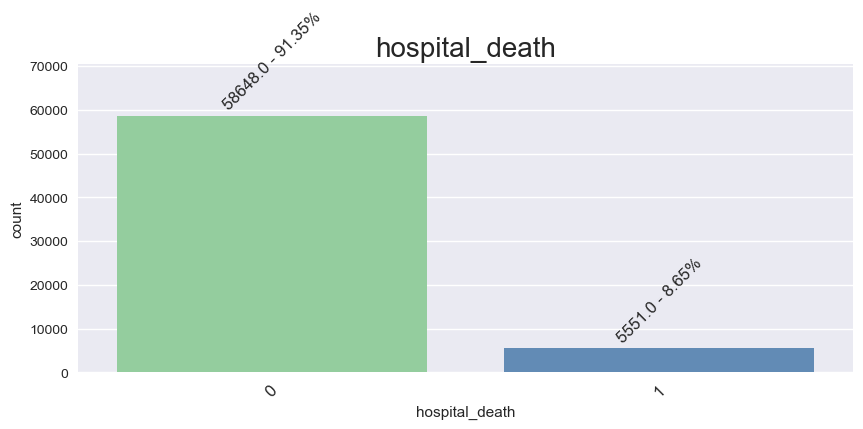

In [9]:
plot(
       'countplot'
     , df =y_train.to_frame()
     , columns= ['hospital_death']
     , ncols=1
     , plot_size = (10,4)
    #  , title=f"Target distribution - {'hospital_death'.title()} - ALL"
)


# Data Preparation

In [4]:
# Defining preprocessor

preprocessor = select_preprocessor('TargetEncoding', X = X_train)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('float',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['weight', 'gcs_unable_apache',
                                  'intubated_apache', 'gcs_verbal_apache',
                                  'immunosuppression', 'd1_temp_min',
                                  'd1_temp_max', 'apache_2_diagnosis',
                                  'd1_glucose_min', 'h1_resprate_min',
                                  'h1_heartrate_min', 'd1_potassium_max',...
                                 ['icu_type', 'icu_admit_source', 'ethnicity',
                                  'icu_stay_type', 'gender',
                                  'apache_3j_bodysystem',
                                  'apache_2_bodysystem']),
                                ('categorical_high_granularity',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder', TargetEncoder())]),
                                 []),
                                ('bypass',
                                 Pipeline(steps=[('Bypass',
                                                  <src.ml.utils.preprocessors.BypassTransformer object at 0x160f5ffd0>)]),
                                 [])])

In [5]:
preprocessor.fit(X_train)

output_features = get_ct_feature_names(preprocessor)

X_train_preprocessed = pd.DataFrame(data = preprocessor.transform(X_train), columns = output_features)
X_test_preprocessed = pd.DataFrame(data = preprocessor.transform(X_test), columns = output_features)

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

X_train.shape:  (64199, 124)
X_test.shape:  (27514, 124)


In [6]:
X_train_preprocessed.sample(10)

,weight,gcs_unable_apache,intubated_apache,gcs_verbal_apache,immunosuppression,d1_temp_min,d1_temp_max,apache_2_diagnosis,d1_glucose_min,h1_resprate_min,h1_heartrate_min,d1_potassium_max,lymphoma,d1_mbp_max,d1_sysbp_noninvasive_max,d1_mbp_noninvasive_max,h1_sysbp_noninvasive_max,apache_4a_hospital_death_prob,h1_sysbp_max,h1_sysbp_min,d1_sysbp_min,h1_sysbp_noninvasive_min,h1_mbp_min,h1_mbp_noninvasive_min,h1_resprate_max,d1_resprate_min,temp_apache,h1_mbp_noninvasive_max,gcs_motor_apache,d1_mbp_noninvasive_min,cirrhosis,d1_heartrate_min,gcs_eyes_apache,age,d1_mbp_min,d1_glucose_max,map_apache,aids,d1_sysbp_noninvasive_min,h1_spo2_max,d1_diasbp_noninvasive_max,leukemia,heart_rate_apache,apache_4a_icu_death_prob,d1_diasbp_min,d1_resprate_max,d1_potassium_min,d1_diasbp_noninvasive_min,resprate_apache,h1_spo2_min,d1_spo2_max,height,d1_heartrate_max,h1_diasbp_noninvasive_max,ventilated_apache,d1_spo2_min,hepatic_failure,d1_diasbp_max,pre_icu_los_days,bmi,h1_heartrate_max,h1_diasbp_min,h1_diasbp_max,apache_3j_diagnosis,h1_diasbp_noninvasive_min,diabetes_mellitus,solid_tumor_with_metastasis,arf_apache,d1_sysbp_max,h1_mbp_max,icu_id,elective_surgery,apache_post_operative,hospital_id,icu_type___-CCU-CTICU,icu_type___-CSICU,icu_type___-CTICU,icu_type___-Cardiac ICU,icu_type___-MICU,icu_type___-Med-Surg ICU,icu_type___-Neuro ICU,icu_type___-SICU,icu_admit_source___-Accident & Emergency,icu_admit_source___-Floor,icu_admit_source___-Operating Room / Recovery,icu_admit_source___-Other Hospital,icu_admit_source___-Other ICU,icu_admit_source___-None,ethnicity___-African American,ethnicity___-Asian,ethnicity___-Caucasian,ethnicity___-Hispanic,ethnicity___-Native American,ethnicity___-Other/Unknown,ethnicity___-None,icu_stay_type___-admit,icu_stay_type___-readmit,icu_stay_type___-transfer,gender___-F,gender___-M,gender___-None,apache_3j_bodysystem___-Cardiovascular,apache_3j_bodysystem___-Gastrointestinal,apache_3j_bodysystem___-Genitourinary,apache_3j_bodysystem___-Gynecological,apache_3j_bodysystem___-Hematological,apache_3j_bodysystem___-Metabolic,apache_3j_bodysystem___-Musculoskeletal/Skin,apache_3j_bodysystem___-Neurological,apache_3j_bodysystem___-Respiratory,apache_3j_bodysystem___-Sepsis,apache_3j_bodysystem___-Trauma,apache_3j_bodysystem___-None,apache_2_bodysystem___-Cardiovascular,apache_2_bodysystem___-Gastrointestinal,apache_2_bodysystem___-Haematologic,apache_2_bodysystem___-Metabolic,apache_2_bodysystem___-Neurologic,apache_2_bodysystem___-Renal/Genitourinary,apache_2_bodysystem___-Respiratory,apache_2_bodysystem___-Trauma,apache_2_bodysystem___-Undefined Diagnoses,apache_2_bodysystem___-Undefined diagnoses,apache_2_bodysystem___-None
11029,-0.41,-0.10,-0.42,0.00,-0.17,0.59,0.02,1.40,0.73,-0.71,1.61,-0.56,-0.07,1.41,1.47,1.43,2.00,-0.15,1.96,2.69,3.06,2.72,2.88,2.92,-1.31,-0.37,0.35,2.12,0.41,3.02,-0.13,2.67,0.57,-1.60,3.01,-0.27,1.55,-0.03,3.06,0.63,0.98,-0.08,1.25,-0.06,2.31,-1.39,-0.97,2.32,2.28,0.74,0.41,-0.25,1.22,1.70,-0.70,0.85,-0.11,0.98,-0.29,-0.33,1.11,2.70,1.70,0.74,2.72,-0.54,-0.15,-0.17,1.46,2.06,0.73,-0.48,-0.50,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3184,0.45,-0.10,-0.42,-1.94,-0.17,-0.09,1.04,1.44,0.10,-0.54,-0.44,-0.40,-0.07,-0.61,0.46,-0.00,-0.68,0.00,-0.68,-0.05,0.88,-0.06,-0.88,-0.00,-1.18,-0.56,-0.26,0.00,0.41,0.00,-0.13,-0.20,0.57,0.96,-0.63,-0.09,-0.79,-0.03,0.88,0.63,-1.30,-0.08,-0.22,-0.00,0.36,-0.65,-0.24,0.36,-1.05,0.44,0.41,1.23,-0.46,-1.17,1.45,0.06,-0.11,-1.29,-0.34,-0.09,0.03,-0.49,-1.13,1.40,-0.52,-0.54,-0.15,-0.17,0.45,-0.93,1.65,2.10,1.99,-0.90,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00

# FEATURE SELECTION

## Colinear Removal

In [7]:
collinear_support, collinear_features, record_collinear = collinear_removal(X_train_preprocessed, y_train, 0.8)

X_train_preprocessed = X_train_preprocessed[collinear_features]
X_test_preprocessed = X_test_preprocessed[collinear_features]

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

33 features with a correlation magnitude greater than 0.80.

X_train.shape:  (64199, 91)
X_test.shape:  (27514, 91)


In [8]:
record_collinear.head()

,drop_feature,corr_feature,corr_value
0,apache_4a_icu_death_prob,apache_4a_hospital_death_prob,0.88
1,d1_sysbp_noninvasive_min,d1_sysbp_min,0.99
2,d1_mbp_noninvasive_min,d1_mbp_min,0.99
3,d1_diasbp_min,d1_mbp_min,0.85
4,d1_diasbp_min,d1_mbp_noninvasive_min,0.85


In [9]:
X_train_preprocessed.sample(10)

,weight,gcs_unable_apache,intubated_apache,gcs_verbal_apache,immunosuppression,d1_temp_min,d1_temp_max,apache_2_diagnosis,d1_glucose_min,h1_resprate_min,d1_potassium_max,lymphoma,d1_mbp_max,apache_4a_hospital_death_prob,h1_sysbp_max,d1_sysbp_min,h1_sysbp_noninvasive_min,h1_resprate_max,d1_resprate_min,temp_apache,h1_mbp_noninvasive_max,gcs_motor_apache,cirrhosis,d1_heartrate_min,gcs_eyes_apache,age,d1_mbp_min,d1_glucose_max,map_apache,aids,h1_spo2_max,leukemia,d1_resprate_max,d1_potassium_min,resprate_apache,h1_spo2_min,d1_spo2_max,height,d1_heartrate_max,ventilated_apache,d1_spo2_min,hepatic_failure,pre_icu_los_days,h1_heartrate_max,apache_3j_diagnosis,diabetes_mellitus,solid_tumor_with_metastasis,arf_apache,d1_sysbp_max,icu_id,elective_surgery,hospital_id,icu_type___-CCU-CTICU,icu_type___-CSICU,icu_type___-CTICU,icu_type___-Cardiac ICU,icu_type___-MICU,icu_type___-Med-Surg ICU,icu_type___-Neuro ICU,icu_type___-SICU,icu_admit_source___-Accident & Emergency,icu_admit_source___-Floor,icu_admit_source___-Other Hospital,icu_admit_source___-Other ICU,icu_admit_source___-None,ethnicity___-African American,ethnicity___-Asian,ethnicity___-Caucasian,ethnicity___-Hispanic,ethnicity___-Native American,ethnicity___-Other/Unknown,ethnicity___-None,icu_stay_type___-readmit,icu_stay_type___-transfer,gender___-M,gender___-None,apache_3j_bodysystem___-Cardiovascular,apache_3j_bodysystem___-Gynecological,apache_3j_bodysystem___-Metabolic,apache_3j_bodysystem___-Musculoskeletal/Skin,apache_3j_bodysystem___-Neurological,apache_3j_bodysystem___-Sepsis,apache_3j_bodysystem___-Trauma,apache_3j_bodysystem___-None,apache_2_bodysystem___-Cardiovascular,apache_2_bodysystem___-Gastrointestinal,apache_2_bodysystem___-Haematologic,apache_2_bodysystem___-Renal/Genitourinary,apache_2_bodysystem___-Respiratory,apache_2_bodysystem___-Undefined Diagnoses,apache_2_bodysystem___-Undefined diagnoses
57327,-1.26,-0.10,2.37,0.65,-0.17,-0.63,-1.00,0.21,-1.80,-0.88,-0.40,-0.07,0.64,-0.32,-0.42,0.64,0.00,-0.91,-0.56,-0.75,0.00,0.41,-0.13,0.10,0.57,1.51,0.46,0.05,-0.38,-0.03,0.63,-0.08,0.01,-0.79,0.48,0.44,0.41,-0.66,-0.96,1.45,0.06,-0.11,-0.33,-0.57,1.40,-0.54,-0.15,-0.17,0.30,-1.81,2.10,0.20,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
61011,0.14,-0.10,-0.42,0.65,-0.17,-0.90,-1.00,-0.85,-1.23,-0.04,-0.56,-0.07,-0.56,0.00,-1.53,-1.01,-1.16,-0.50,0.23,-0.99,-1.21,0.41,-0.13,-0.25,0.57,0.53,-0.44,-1.00,2.20,-0.03,-0.02,-0.08,-0.27,-0.06,0.01,-0.33,-0.68,0.03,-0.41,-0.70,-0.04,-0.11,-0.13,-0.39,-0.13,-0.54,-0.15,-0.17,-0.79,-0.59,-0.48,0.48,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
17889,-0.23,-0.10,2.37,0.65,-0.17,1.26,1.19,-0.76,0.51,-0.20,-0.40,-0.07,-0.80,0.10,0.92,0.93,1.63,-0.91,0.03,0.96,0.00,0.41,-0.13,0.45,0.57,-0.14,-0.25,0.26,1.00,-0.03,-0.98,-0.08,-0.83,0.12,-0.99,-0.03,0.41,-1.61,0.09,1.45,0.45,-0.11,-0.28,-0.00,-0.35,1.86,-0.15,-0.17,0.38,0.47,-0.48,-1.06,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
24106,0.50,-0.10,-0.42,0.65,-0.17,-0.09,-0.71,-0.86,-0.04,-1.38,-0.24,-0.07,1.27,-0.28,0.92,0.15,0.00,-1.72,-0.76,0.47,0.00,0.41,-0.13,0.33,0.57,-0.81,1.09,-0.66,1.24,-0.03,-0.02,-0.08,-0.55,0.30,-1.32,0.44,0.41,0.99,-0.00,-0.70,0.35,-0.11,-0.32,-0.66,-0.98,-0.54,-0.15,-0.17,0.38,1.51,-0.48,1.31,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
15273,0.16,-0.10,-0.42,0.65,-0.17,0.86,-0.12,0.20,-0.01,0.13,-0.24,-0.07,0.74,-4.58,0.81,1.60,0.00,-0.63,0.23,0.59,0.00,0.41,-0.13,0.

## Voting Process

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]

Optimum number of features: 48
Score (roc_auc) with 48 features: 89.186881
[2022_12_12-09_18_22] TE: 28 seconds


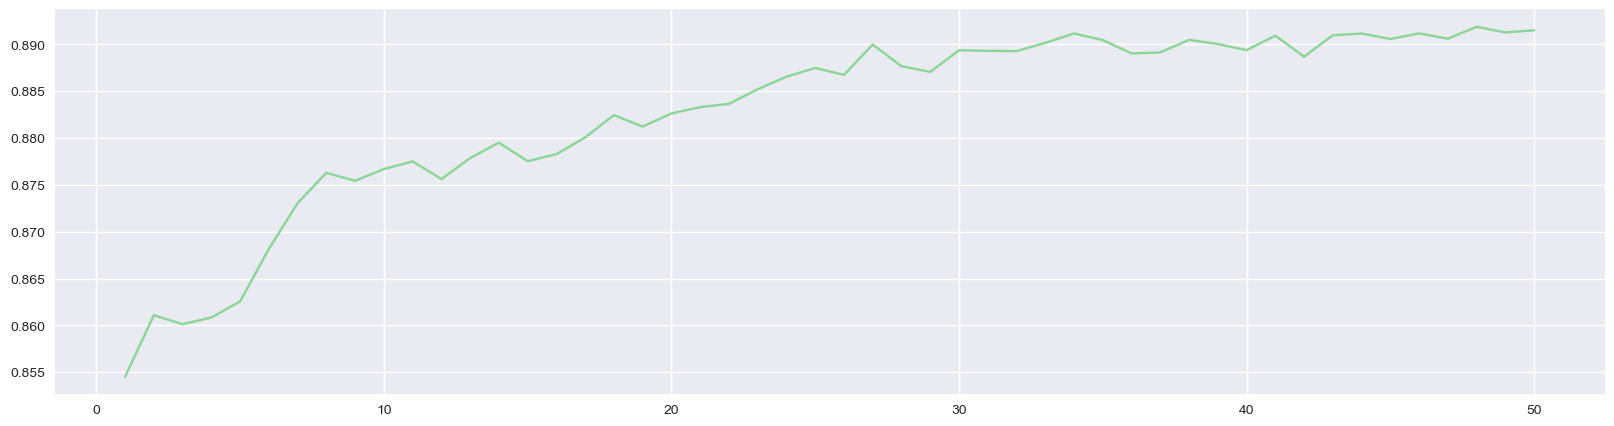

In [10]:
k_best_support, k_best_features=loop_k_features(
                                            X=X_train_preprocessed
                                            , y=y_train
                                            , model=LGBMClassifier(random_state=SEED)
                                            , method='KBest'
                                            , metric = 'roc_auc'
                                            , max_features = 50
                                        )


In [11]:
# rfe_support, rfe_features=loop_k_features(
#                                             X=X_train_preprocessed
#                                             , y=y_train
#                                             , model=LGBMClassifier(random_state=SEED)
#                                             , method='RFE'
#                                             , metric = 'roc_auc'
#                                             , max_features = 50
#                                         )


100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Optimum number of features: 43
Score (roc_auc) with 43 features: 89.566003
[2022_12_12-09_19_29] TE: 1 minutes e 7 seconds


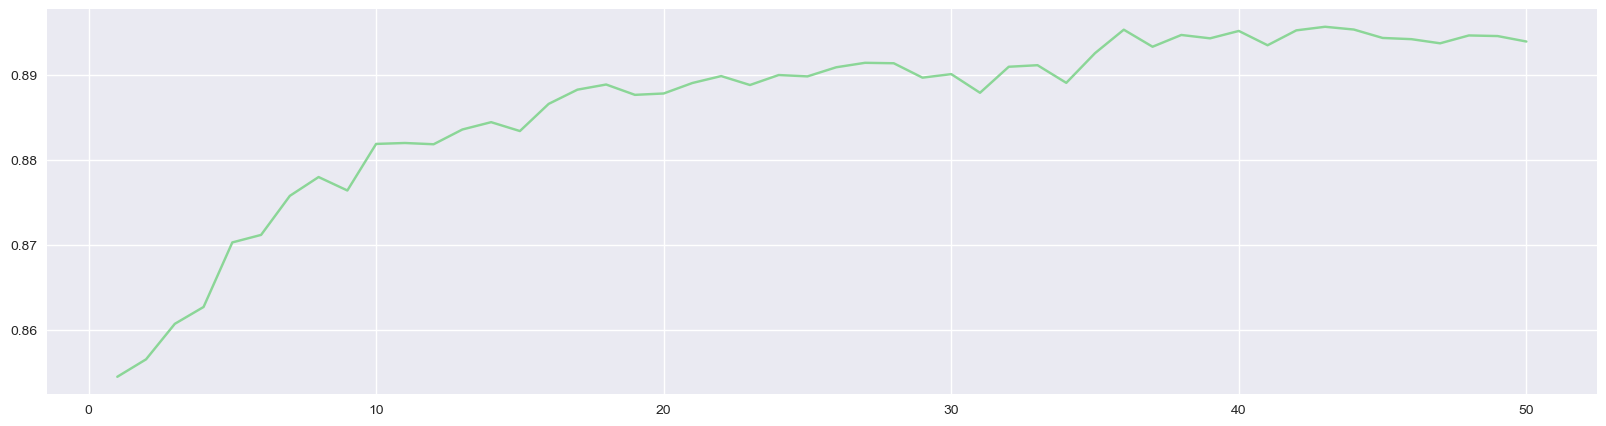

In [12]:
FM_support, FM_features=loop_k_features(
                                        X=X_train_preprocessed
                                        , y=y_train
                                        , model=LGBMClassifier(random_state=SEED)
                                        , method='FromModel'
                                        , metric = 'roc_auc'
                                        , max_features = 50
                                    )

Best alpha using built-in LassoCV: 0.004176
Best score using built-in LassoCV: 0.201388
Lasso picked 34 variables and eliminated the other 57 variables


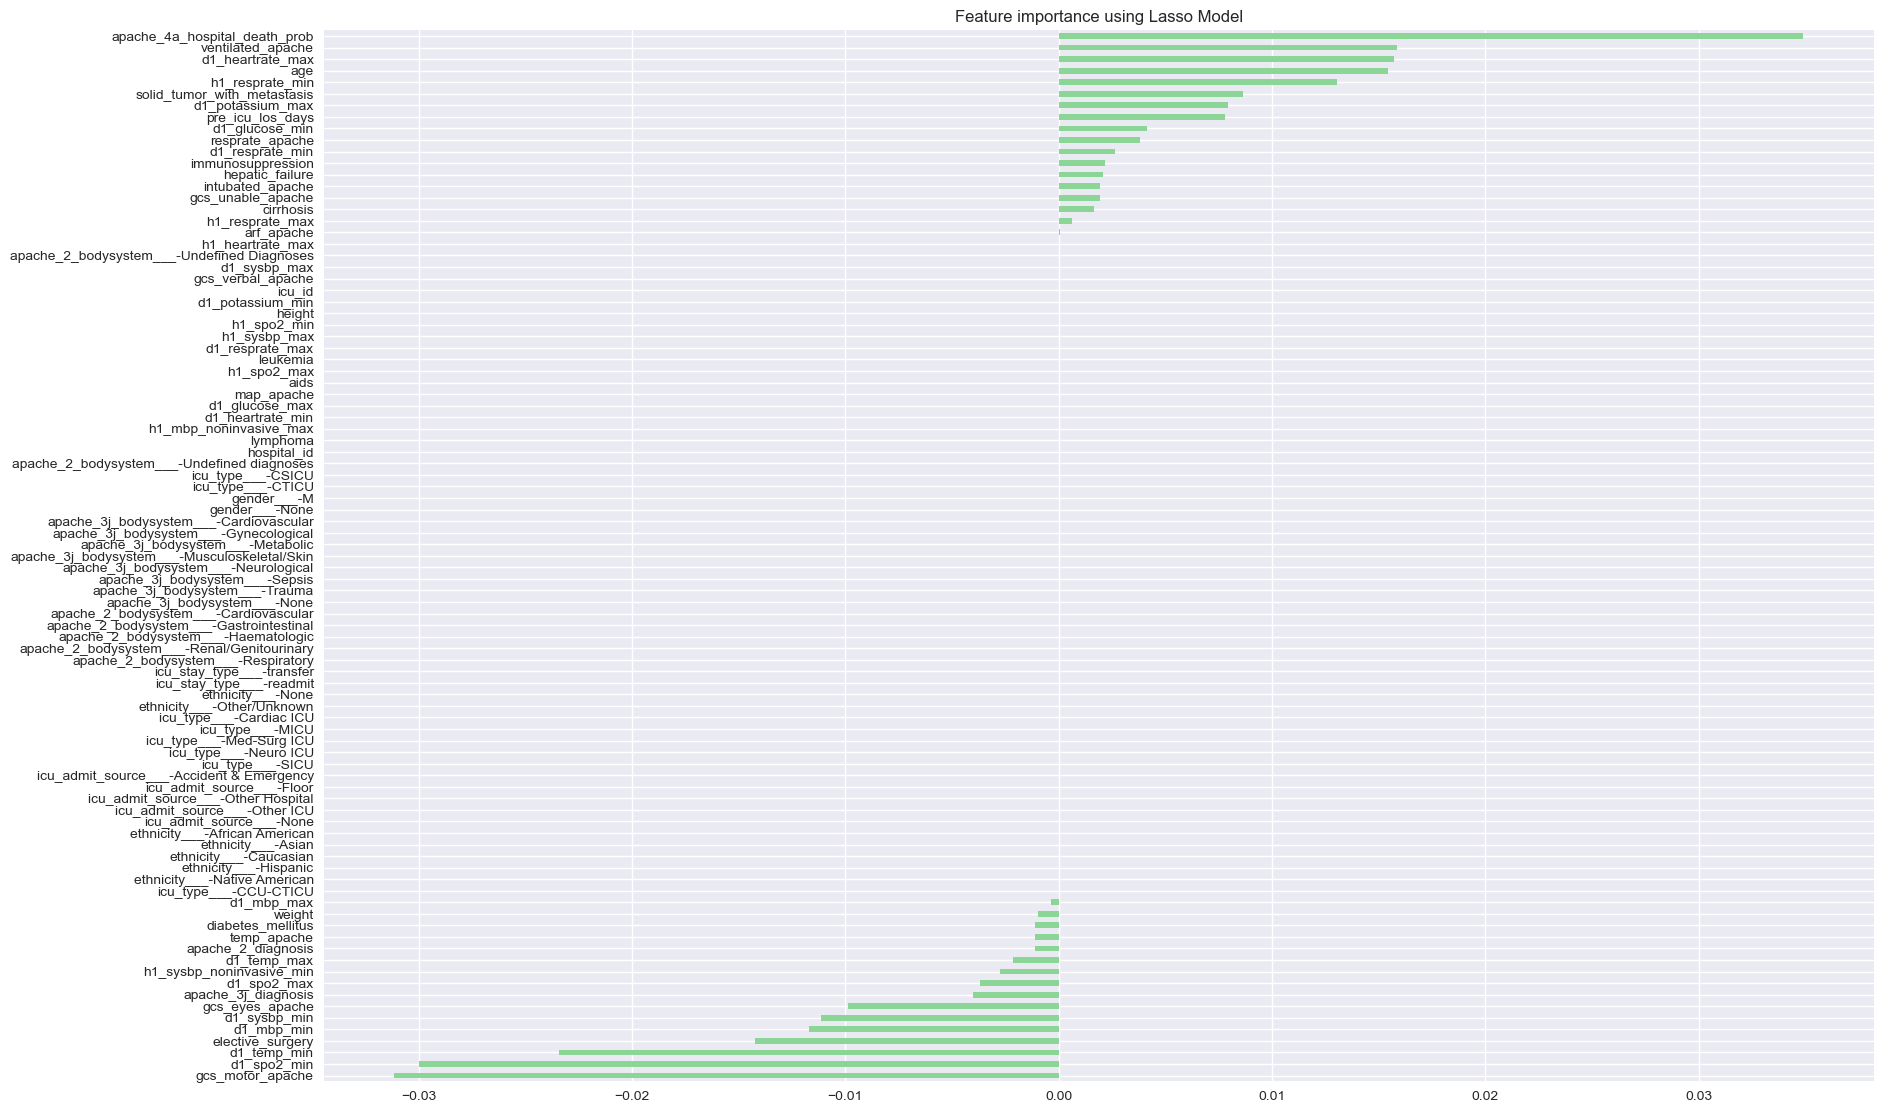

In [13]:
Lasso_support, Lasso_features = Lasso_selection(X=X_train_preprocessed, y=y_train,eps=0.05, n_alphas=100,cv=5)

In [14]:
borutashap_support, borutashap_features = BorutaShap_selection(
      X=X_train_preprocessed
    , y=y_train
    , model=LGBMClassifier(n_estimators = 100, random_state=SEED)
    , kwargs={"n_trials": 100, "random_state": 0, "normalize": False, "verbose": False}
)

Starting BorutaShap



  0%|          | 0/100 [00:00<?, ?it/s]

1 tentative features are now accepted: ['d1_mbp_max']
0 tentative features are now rejected: []
BorutaShap picked 31 variables and eliminated the other 60 variables


In [15]:
# original_features = X_train.columns

# selected_features_original = list(set([
#             input_col
#             for input_col in original_features
#             if any(
#                 input_col == selected_col.split("___-")[0]
#                 for selected_col in borutashap_features
#             )
#         ]))

# X_train_selected=X_train[selected_features_original]
# X_test_selected=X_test[selected_features_original]

# if not osp.exists(osp.join(osp.join('..', 'data', 'feature_selection', 'boruta'))):
#     os.mkdir(osp.join(osp.join('..', 'data', 'feature_selection', 'boruta')))
    
# print('X_train.shape: ', X_train_selected.shape)
# print('X_test.shape: ', X_test_selected.shape)

# pd.concat([X_train_selected,y_train], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'boruta', 'df_train.parquet'))
# pd.concat([X_test_selected,y_test], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'boruta', 'df_test.parquet'))

In [16]:
voting_dict={'Features': X_train_preprocessed.columns
             ,'KBest':k_best_support
            #  ,'RFE': rfe_support
             ,'FM':FM_support
             ,'Lasso':Lasso_support
             ,'BorutaShap':borutashap_support
             }

selected_features, feature_selection_df=voting(voting_dict,threshold=3)
feature_selection_df

,Features,KBest,FM,Lasso,BorutaShap,Total
1,weight,True,True,True,True,4
2,ventilated_apache,True,True,True,True,4
3,resprate_apache,True,True,True,True,4
4,pre_icu_los_days,True,True,True,True,4
5,h1_resprate_min,True,True,True,True,4
6,gcs_motor_apache,True,True,True,True,4
7,d1_temp_min,True,True,True,True,4
8,d1_sysbp_min,True,True,True,True,4
9,d1_spo2_min,True,True,True,True,4
10,d1_resprate_min,True,True,True,True,4


In [17]:
original_features = X_train.columns

selected_features_original = list(set([
            input_col
            for input_col in original_features
            if any(
                input_col == selected_col.split("___-")[0]
                for selected_col in selected_features
            )
        ]))

In [19]:
X_train_selected=X_train[selected_features_original]
X_test_selected=X_test[selected_features_original]

print('X_train.shape: ', X_train_selected.shape)
print('X_test.shape: ', X_test_selected.shape)

X_train.shape:  (64199, 31)
X_test.shape:  (27514, 31)


In [21]:
if not osp.exists(osp.join(osp.join('..', 'data', 'feature_selection', 'fs'))):
    os.mkdir(osp.join(osp.join('..', 'data', 'feature_selection', 'fs')))

pd.concat([X_train_selected,y_train], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'fs','df_train.parquet'))
pd.concat([X_test_selected,y_test], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'fs','df_test.parquet'))

# Feature Selection - SMOTEENN

In [10]:
# reading files
df_train=pd.read_parquet(osp.join(DATA_DIR_RAW,'df_train.parquet')).sample(10000)
df_test=pd.read_parquet(osp.join(DATA_DIR_RAW,'df_test.parquet')).sample(1000)

X_train, X_test, y_train, y_test  = df_train.drop(TARGET, axis = 1), df_test.drop(TARGET, axis = 1), df_train[TARGET], df_test[TARGET]

In [11]:

preprocessor = select_preprocessor('TargetEncoding', X = X_train)

imb_preprocessor = Imb_Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("sampling", SMOTEENN())
])

imb_preprocessor.fit(X_train, y_train)

output_features = get_ct_feature_names(imb_preprocessor[0])

X_resampled, y_resampled = imb_preprocessor.fit_resample(X_train, y_train)

X_train_preprocessed = pd.DataFrame(data = X_resampled, columns = output_features)
X_test_preprocessed = pd.DataFrame(data = imb_preprocessor[0].transform(X_test), columns = output_features)

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

X_train.shape:  (14875, 124)
X_test.shape:  (1000, 124)


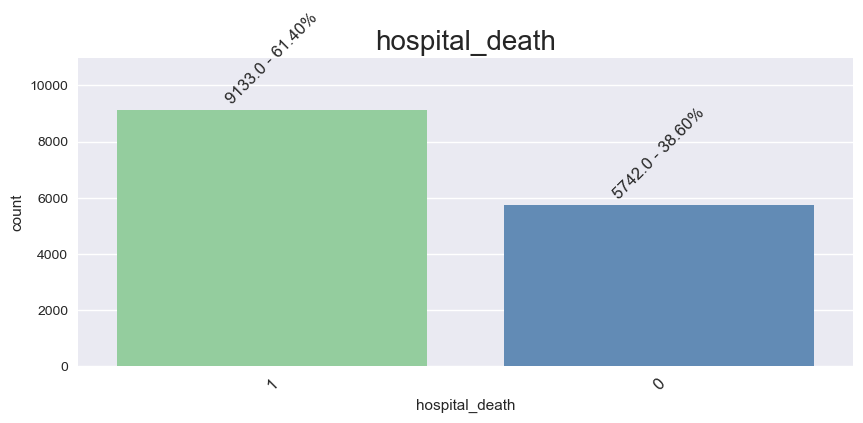

In [12]:
plot(
       'countplot'
     , pd.DataFrame(y_resampled)
     , 'hospital_death'
     , ncols=1
     , plot_size = (10,4)
)

## Colinear Removal

In [6]:
collinear_support, collinear_features, record_collinear = collinear_removal(X_train_preprocessed, y_train, 0.8)

X_train_preprocessed = X_train_preprocessed[collinear_features]
X_test_preprocessed = X_test_preprocessed[collinear_features]

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

37 features with a correlation magnitude greater than 0.80.

X_train.shape:  (95885, 87)
X_test.shape:  (27514, 87)


## Voting Process

100%|██████████| 50/50 [00:52<00:00,  1.06s/it]

Optimum number of features: 50
Score (roc_auc) with 50 features: 99.529323
[2022_12_12-11_31_31] TE: 53 seconds


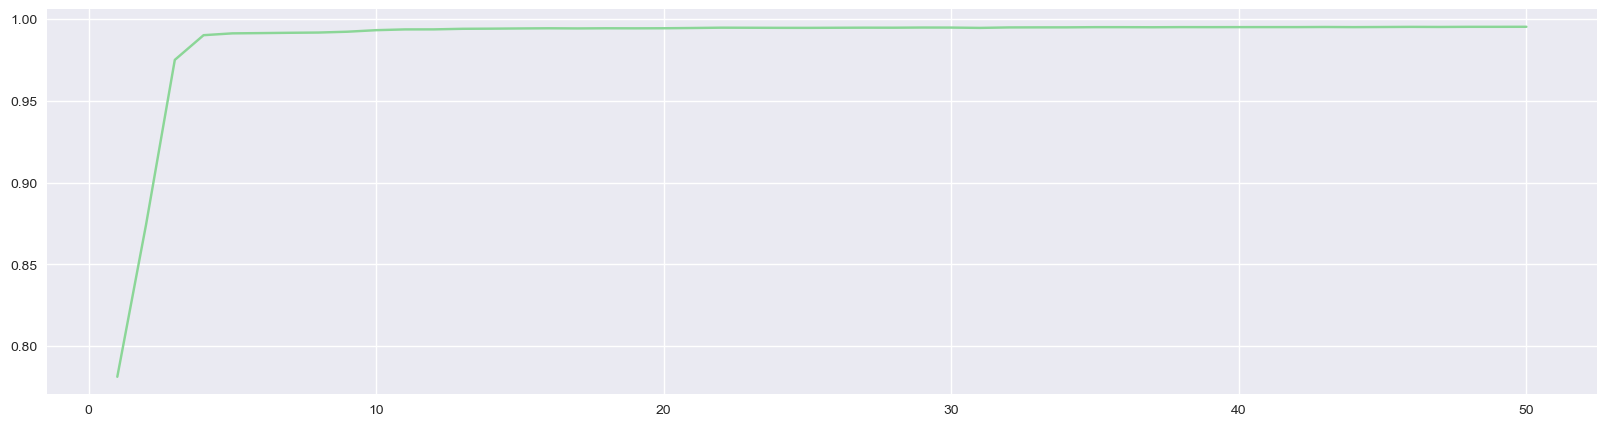

In [7]:
k_best_support, k_best_features=loop_k_features(
                                            X=X_train_preprocessed
                                            , y=y_resampled
                                            , model=LGBMClassifier(random_state=SEED)
                                            , method='KBest'
                                            , metric = 'roc_auc'
                                            , max_features = 50
                                        )


In [8]:
# rfe_support, rfe_features=loop_k_features(
#                                             X=X_train_preprocessed
#                                             , y=y_resampled
#                                             , model=LGBMClassifier(random_state=SEED)
#                                             , method='RFE'
#                                             , metric = 'roc_auc'
#                                             , max_features = 50
#                                         )


100%|██████████| 50/50 [02:06<00:00,  2.53s/it]

Optimum number of features: 37
Score (roc_auc) with 37 features: 99.558112
[2022_12_12-11_33_38] TE: 2 minutes e 6 seconds


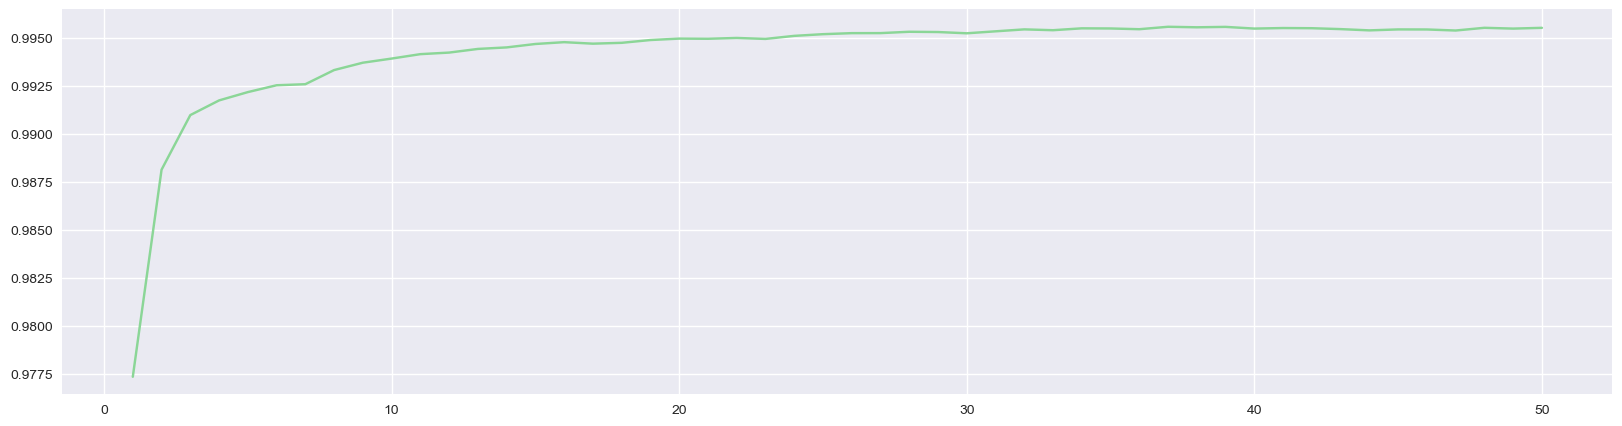

In [9]:
FM_support, FM_features=loop_k_features(
                                        X=X_train_preprocessed
                                        , y=y_resampled
                                        , model=LGBMClassifier(random_state=SEED)
                                        , method='FromModel'
                                        , metric = 'roc_auc'
                                        , max_features = 50
                                    )

Best alpha using built-in LassoCV: 0.012516
Best score using built-in LassoCV: 0.489788
Lasso picked 30 variables and eliminated the other 57 variables


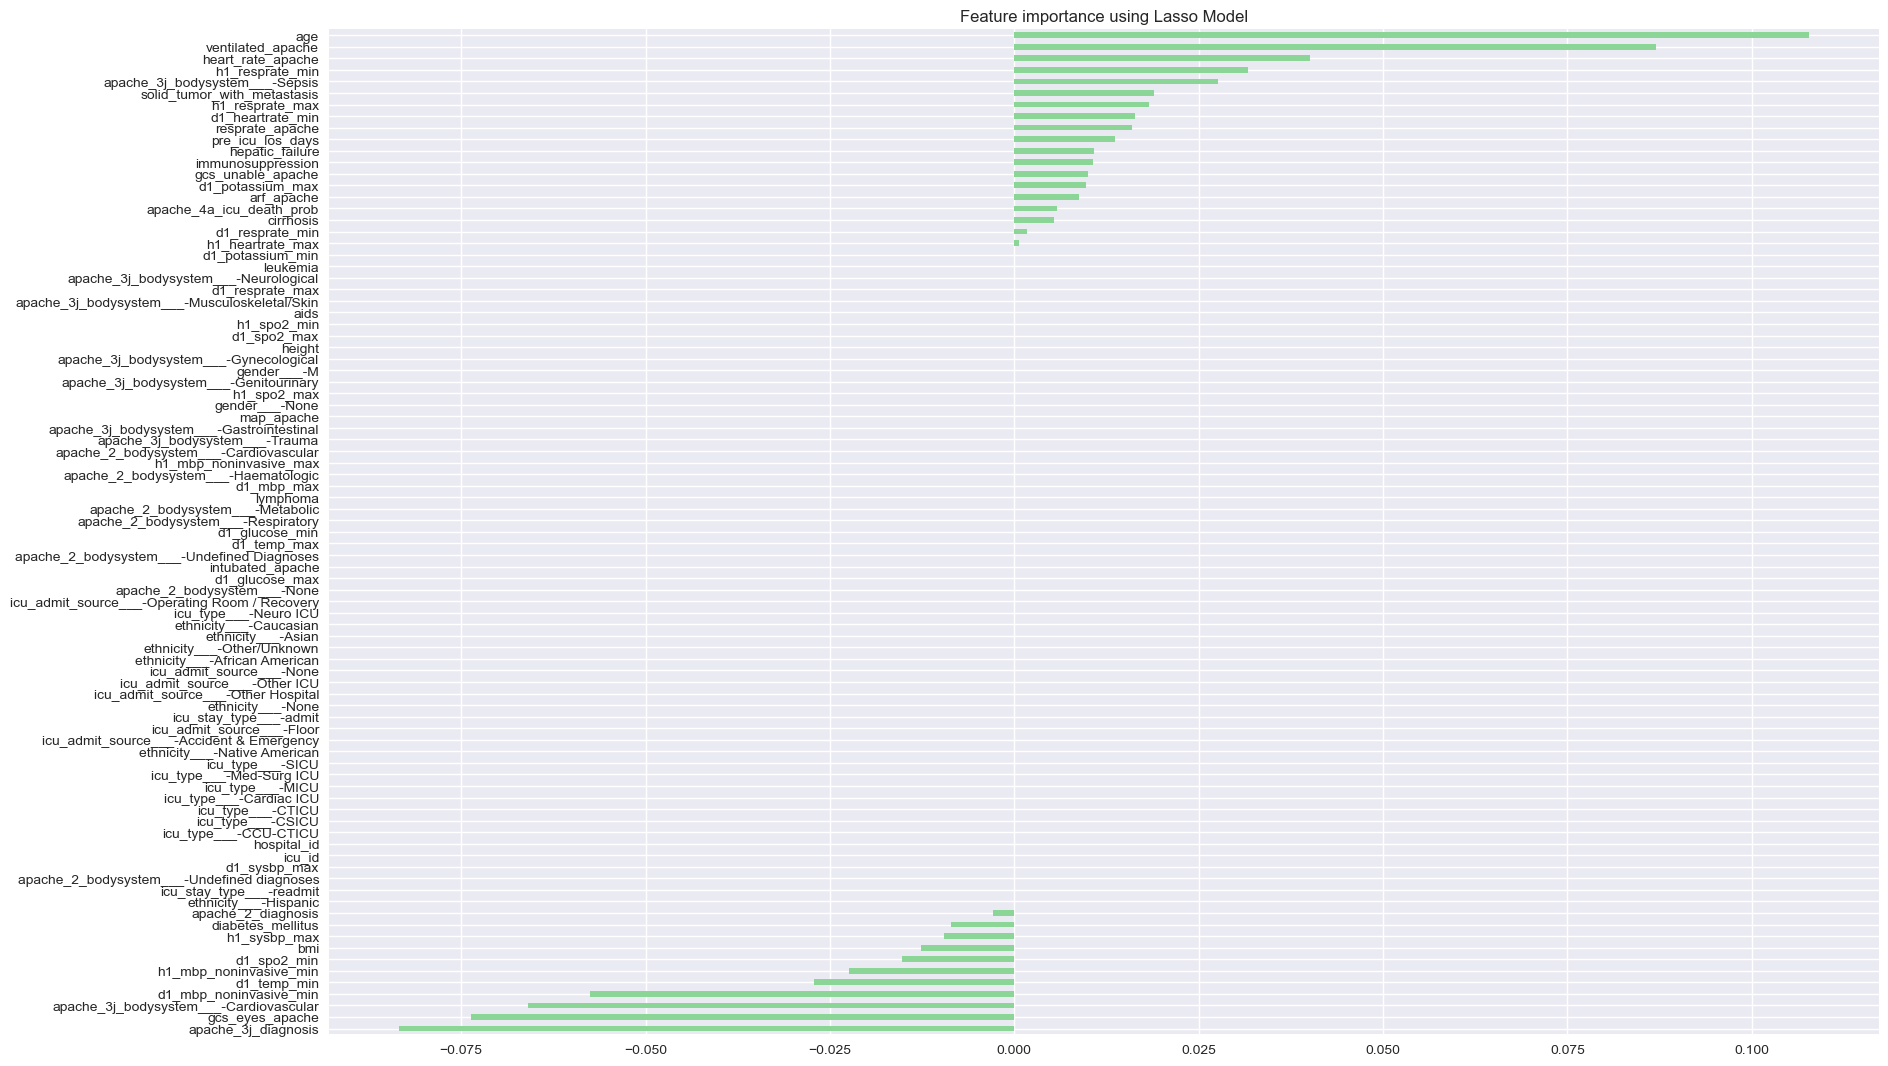

In [10]:
Lasso_support, Lasso_features = Lasso_selection(X=X_train_preprocessed, y=y_resampled,eps=0.05, n_alphas=100,cv=5)

In [11]:
borutashap_support, borutashap_features = BorutaShap_selection(
      X=X_train_preprocessed
    , y=y_resampled
    , model=LGBMClassifier(n_estimators = 100, random_state=SEED)
    , kwargs={"n_trials": 100, "random_state": 0, "normalize": False, "verbose": False}
)

Starting BorutaShap



  0%|          | 0/100 [00:00<?, ?it/s]

2 tentative features are now accepted: ['aids' 'd1_mbp_max']
1 tentative features are now rejected: ['ethnicity___-African American']
BorutaShap picked 61 variables and eliminated the other 26 variables


In [12]:
voting_dict={'Features':X_train_preprocessed.columns
             ,'KBest':k_best_support
            #  ,'RFE': rfe_support
             ,'FM':FM_support
             ,'Lasso':Lasso_support
             ,'BorutaShap':borutashap_support
             }

selected_features, feature_selection_df=voting(voting_dict,threshold=3)
feature_selection_df

,Features,KBest,FM,Lasso,BorutaShap,Total
1,ventilated_apache,True,True,True,True,4
2,resprate_apache,True,True,True,True,4
3,pre_icu_los_days,True,True,True,True,4
4,heart_rate_apache,True,True,True,True,4
5,h1_sysbp_max,True,True,True,True,4
6,h1_resprate_min,True,True,True,True,4
7,h1_resprate_max,True,True,True,True,4
8,h1_heartrate_max,True,True,True,True,4
9,gcs_eyes_apache,True,True,True,True,4
10,diabetes_mellitus,True,True,True,True,4


In [13]:
original_features = X_train.columns

selected_features_original = list(set([
            input_col
            for input_col in original_features
            if any(
                input_col == selected_col.split("___-")[0]
                for selected_col in selected_features
            )
        ]))

In [22]:
X_train_raw_smoteen=X_train[selected_features_original]
X_test_selected=X_test[selected_features_original]

print('X_train_raw_smoteen.shape: ', X_train_raw_smoteen.shape)
print('X_test.shape: ', X_test_selected.shape)

X_train_raw_smoteen.shape:  (64199, 31)
X_test.shape:  (27514, 31)


In [23]:
if not osp.exists(osp.join('..', 'data', 'feature_selection', 'smoteenn','df_train.parquet')):
    os.mkdir(osp.join('..', 'data', 'feature_selection', 'smoteenn'))
    
# pd.concat([X_train_selected,y_train], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'smoteenn','resampled','df_train.parquet'))
# pd.concat([X_test_selected,y_test], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'smoteenn', 'resampled','df_test.parquet'))

pd.concat([X_train_raw_smoteen,y_train], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'smoteenn','df_train.parquet'))
pd.concat([X_test_selected,y_test], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'smoteenn', 'df_test.parquet'))